# 1. Scope

The objective of this document will be to develop a Machine Learning model that, given a review, allows it to be classified into a score from 1 to 5. For this, I have 3 datasets with existing reviews and their respective classifications.

First, an exploration of the dataset will be carried out for a more exhaustive understanding of its characteristics. Then the reviews will be pre-processed to be able to work more easily with them to, finally, find the best Machine Learning model that allows to carry out this classification problem with new data.

Finally, an analysis of the conclusions obtained and a meta-analysis of the applied methodology will be carried out.

Disclaimer: the dataset has reviews in spanish, so some translation will be done to clarify what some sentences mean in english.

Import relevant libraries

In [1]:
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import random

import es_core_news_sm

from collections import Counter
import itertools
from wordcloud import WordCloud

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

Load datasets

In [2]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

# 2. EDA and preprocessing

## Scope

The objective of this section will be to determine the characteristics of the dataset provided and to do some preprocessing to perform NLP in the future.

## EDA

Both the training dataset and the test dataset have <code>5,000 reviews</code>, while the training dataset has <code>200,000 reviews</code>

In [3]:
print(df.shape)
print(df_test.shape)
print(df_train.shape)

(5000, 8)
(5000, 8)
(200000, 8)


Each review has 7 attributes:
- Review ID (`review_id`)
- Product ID (<code>product_id</code>)
- Reviewer ID (<code>reviewer_id</code>)
- Stars (<code>stars</code>)
- Review body (<code>review_body</code>)
- Review title (<code>review_title</code>)
- Language (<code>language</code>)
- Product category (<code>product_category</code>)

None of which have missing values

In [4]:
display(df.info())
display(df_test.info())
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


None

Looking very superficially at the dataset, I have some questions that I would like to answer:
- Are all the reviews made in the same language?
- How many categories does the dataset have? Do they all have the same number of reviews?
- Do people rate products with better or worse scores more?
- What are the categories that receive the highest number of reviews? Which are the most criticized and the ones that receive the best scores?
- What are the most common words for each score in the reviews?

All reviews are written in Spanish

In [5]:
print(df['language'].unique())
print(df_test['language'].unique())
print(df_train['language'].unique())

['es']
['es']
['es']


According to what is expressed in the download page of this dataset ([Link](https://registry.opendata.aws/amazon-reviews-ml/)), all reviews were collected between **November 1, 2015** and **November 1, 2019**

Since exploring the entire dataset is difficult to work with all 3 dataframes separately, I will concatenate them below

In [6]:
df_amazon = pd.concat([df,df_test,df_train],axis=0)
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  
0                         Mala compra       es          wireless  
1                   No lo he recibido       es           apparel  
2  Que no aprieta bien en el manillar       es            sports  
3               Brocas de mantequilla       es  home_improvement  
4                         No me gusta       es            beauty

In [7]:
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  
0                         Mala compra       es          wireless  
1                   No lo he recibido       es           apparel  
2  Que no aprieta bien en el manillar       es            sports  
3               Brocas de mantequilla       es  home_improvement  
4                         No me gusta       es            beauty

I can see from the following graph that each score has the same number of associated reviews, which implies that it is *balanced*

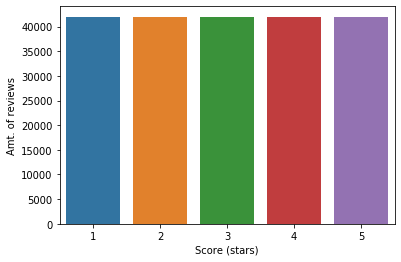

In [8]:
sns.countplot(x = 'stars', data = df_amazon)
plt.ylabel('Amt. of reviews')
plt.xlabel('Score (stars)')

plt.show()

In [9]:
print('There are',str(len(df_amazon['product_category'].unique())),'unique categories in current dataset')

There are 30 unique categories in current dataset


We can see that reviews of products in **`home`** and **`wireless`** categories predominate, followed by **`toys`** and **`sports`**

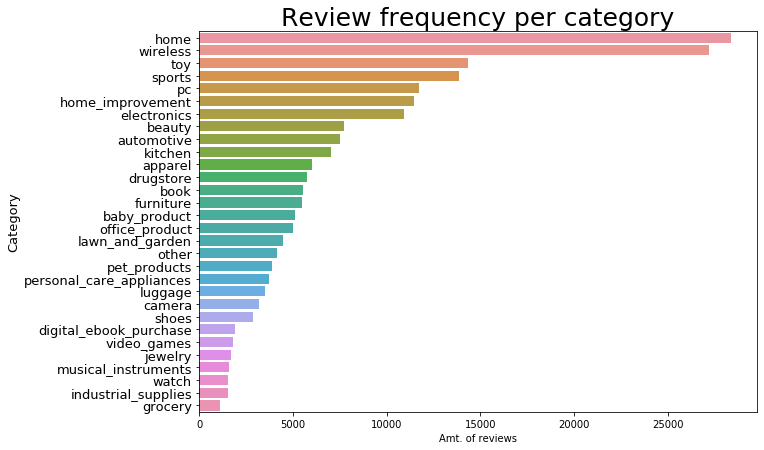

In [10]:
plt.figure(figsize = (10,7))

sns.countplot(y = 'product_category', 
              data = df_amazon,  
              order = df_amazon.product_category.value_counts().index)
plt.ylabel('Category',size=13)
plt.xlabel('Amt. of reviews')
plt.tick_params(axis='y', labelsize=13)
plt.title('Review frequency per category', size=25)
plt.show()

The top 3 best valued categories are `books`, `digital_ebook_purchase`, `luggage`, while the 3 most criticized They are `apparel`, `wireless` and `lawn and garden`

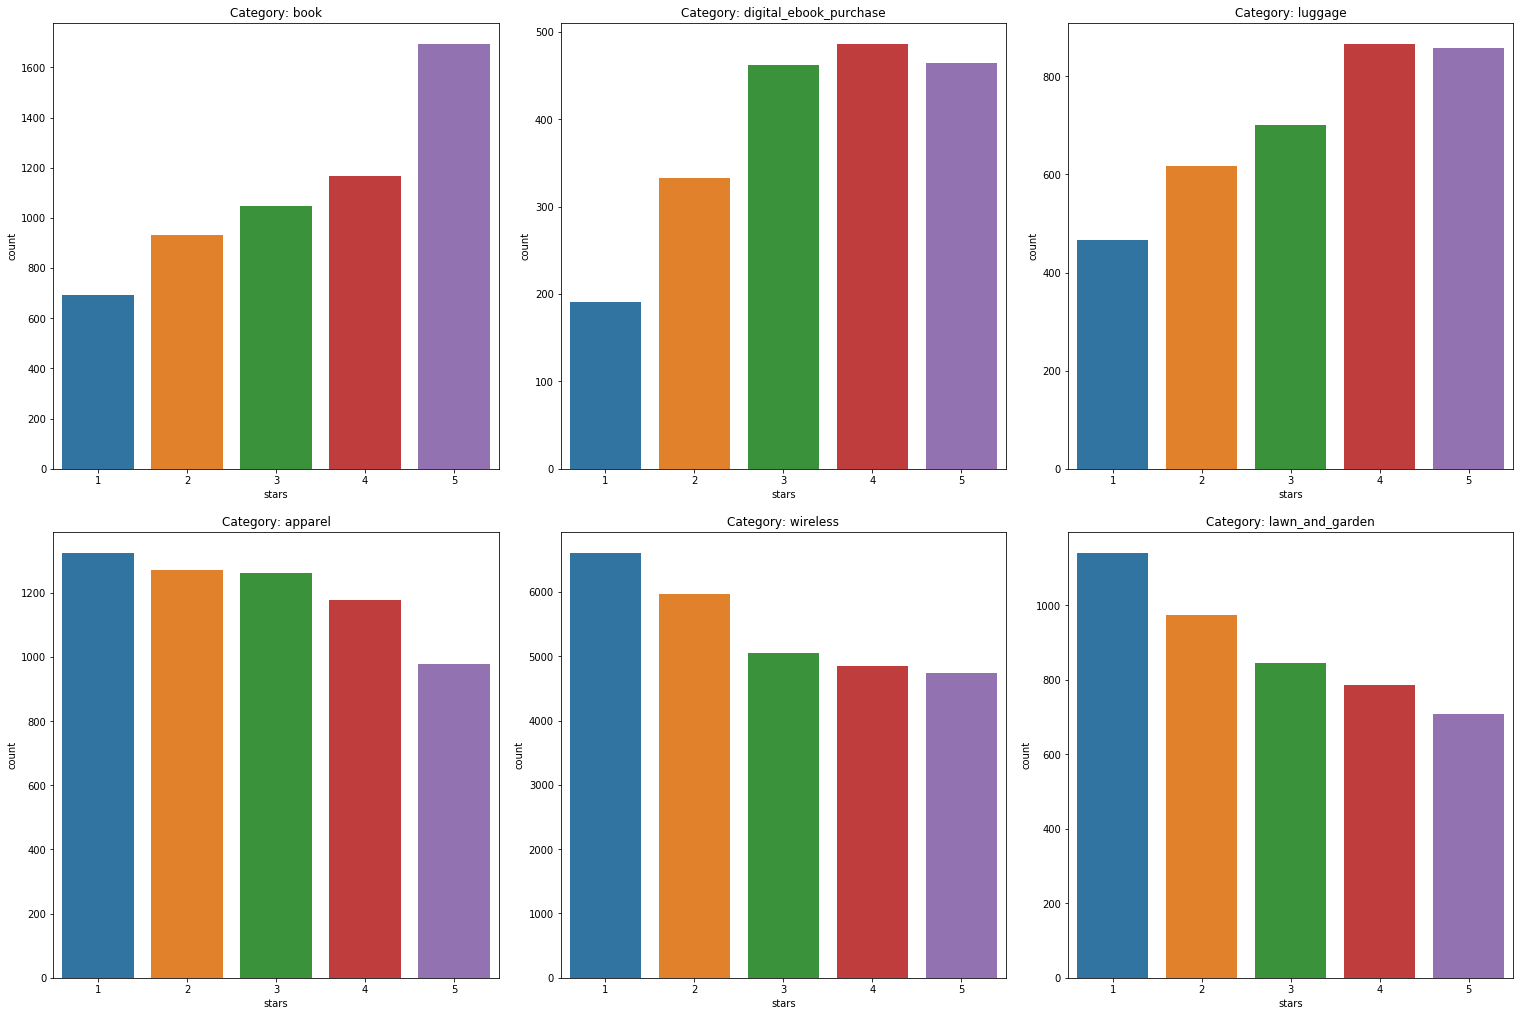

In [11]:
mean_p = df_amazon.groupby(['product_category'])[['stars']].mean().sort_values(by='stars', ascending=False)
first_three = list(mean_p.iloc[:3].reset_index()['product_category'])
last_three = list(mean_p.iloc[27:].reset_index()['product_category'])
first_three.extend(last_three)

num_plots = len(first_three)
total_cols = 3
total_rows = num_plots//total_cols

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)


for i, ax in enumerate(axs.flatten()):
    row = i//total_cols
    pos = i % total_cols
    sns.countplot(x='stars', data=df_amazon[df_amazon['product_category']== first_three[i]], ax=axs[row][pos])
    ax.set_title('Category: {}'.format(first_three[i]))
plt.show()

## Review preprocessing

Next, and in order to be able to analyze the reviews more easily, I will unite in the same column `full_review` the reviews with their titles

In [12]:
df_amazon['full_review'] = df_amazon['review_title']+ ' ' + df_amazon['review_body']
df_amazon.reset_index(inplace=True,drop=True)
df_amazon.head(5)

review_id          product_id          reviewer_id  stars  \
0  es_0417480  product_es_0873923  reviewer_es_0672978      1   
1  es_0180432  product_es_0713146  reviewer_es_0100858      1   
2  es_0144850  product_es_0356874  reviewer_es_0486447      1   
3  es_0339629  product_es_0939832  reviewer_es_0894703      1   
4  es_0858362  product_es_0489066  reviewer_es_0887663      1   

                                         review_body  \
0  Malisimo, muy grande demasiado aparatoso y mal...   
1          No he recibido el pedido no la devolución   
2  Tengo que buscar otro sistema, este no funcion...   
3  Utilicé las brocas de menor diámetro y se me d...   
4         No me gusta su olor a viejo y aspecto malo   

                         review_title language  product_category  \
0                         Mala compra       es          wireless   
1                   No lo he recibido       es           apparel   
2  Que no aprieta bien en el manillar       es            sports   
3               Brocas de mantequilla       es  home_improvement   
4                         No me gusta       es            beauty   

                                         full_review  
0  Mala compra Malisimo, muy grande demasiado apa...  
1  No lo he recibido No he recibido el pedido no ...  
2  Que no aprieta bien en el manillar Tengo que b...  
3  Brocas de mantequilla Utilicé las brocas de me...  
4  No me gusta No me gusta su olor a viejo y aspe...

In the next cell:
- I will load the `pipeline` in Spanish of **`spaCy`**. This, as can be seen in the diagram below, applies some transformations to the text that we pass through it. According to its documentation, the applied transformations are: `tok2vec`, `morphologizer`, `parser`, `ner`, `attribute_ruler` and `lemmatizer`.

<img src="https://d33wubrfki0l68.cloudfront.net/3ad0582d97663a1272ffc4ccf09f1c5b335b17e9/7f49c/pipeline-fde48da9b43661abcdf62ab70a546d71.svg" alt="Drawing" style="width: 600px;"/>

- I will load the common words (stopwords) in Spanish and then filter them

In [13]:
nlp = es_core_news_sm.load()

sw = nlp.Defaults.stop_words

Through the following function I will apply **`normalization`** to the text of each row. This includes:
- The preprocessing mentioned above with `nlp`
- All words will become lowercase
- Commas, periods and 1-letter words will be eliminated (for example "y" [eng: *and*], "a" [eng: *to*], etc)
- The `stopwords` will be removed. These are words that are meaningless on their own, such as prepositions, articles, conjunctions, pronouns, etc.

The objective of this preprocessing, which will reduce text noise by eliminating inflectional and sometimes derivationally related forms to a common base *, is to facilitate the subsequent analysis of each review using classification algorithms. In this way, the number of stars that a user would give a product given a review can be predicted with greater precision.

\* "**Stemming and lemmatization", Stanford, Cambridge University Press, 2008, https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html**

Although in the following function the tokenization and elimination of stopwords of the first 2 lines of the same can be redundant since this is done later when calling the `spaCy` pipeline, this was done anyway due to Because it misinterprets words like "para" [eng: *for*] and transforms them into "parir" [eng: *to give birth*], which affects the result.

Performing stopword filtering without having done the previous lemmatization will eliminate words such as "para"

In [18]:
def process(text):
    review_tk = nltk.RegexpTokenizer('\w+').tokenize(text)
    review_tk_min = [word.lower() for word in review_tk if word.lower() not in sw]
    review_clean = ' '.join(review_tk_min)
    review_clean = nlp(review_clean)
    review_lemm = [word.lemma_ for word in review_clean]
    review_lemm = [t for t in review_lemm if len(t)>1]
    return review_lemm

Here is an example of preprocessing:

In [19]:
x = 119
print("Text without processing:")
print(df_amazon.full_review[x])
print("----------------")
print("Processed text:")
print(process(df_amazon.full_review[x]))

Text without processing:
El producto no llegó Se inventaron la excusa más cutre para no enviarme el producto. Un terremoto hizo que no me llegara este producto.
----------------
Processed text:
['producto', 'inventar', 'excusa', 'cutre', 'enviar yo', 'producto', 'terremoto', 'llegar', 'producto']


I apply this to each row of the `full_review` column

In [21]:
df_amazon['full_review_tk'] = df_amazon.apply(lambda row: process(row['full_review']), axis=1)

Since the preprocessing of the dataset consumes many resources and therefore takes a few hours to run, I save this instance in an Excel file for later loading as a checkpoint.

In [22]:
df_amazon.to_excel('Preprocessed.xlsx')

I will show the 5 most common words in each group of reviews (grouped by number of stars) using the following function, then print a word cloud for each one and plot the 20 most frequent words on a bar graph

5 most common words for 1 star reviews
       Words  Frequency
0   producto      10042
1    calidad       7094
2       malo       7042
3  funcionar       6664
4     llegar       4616
-------------


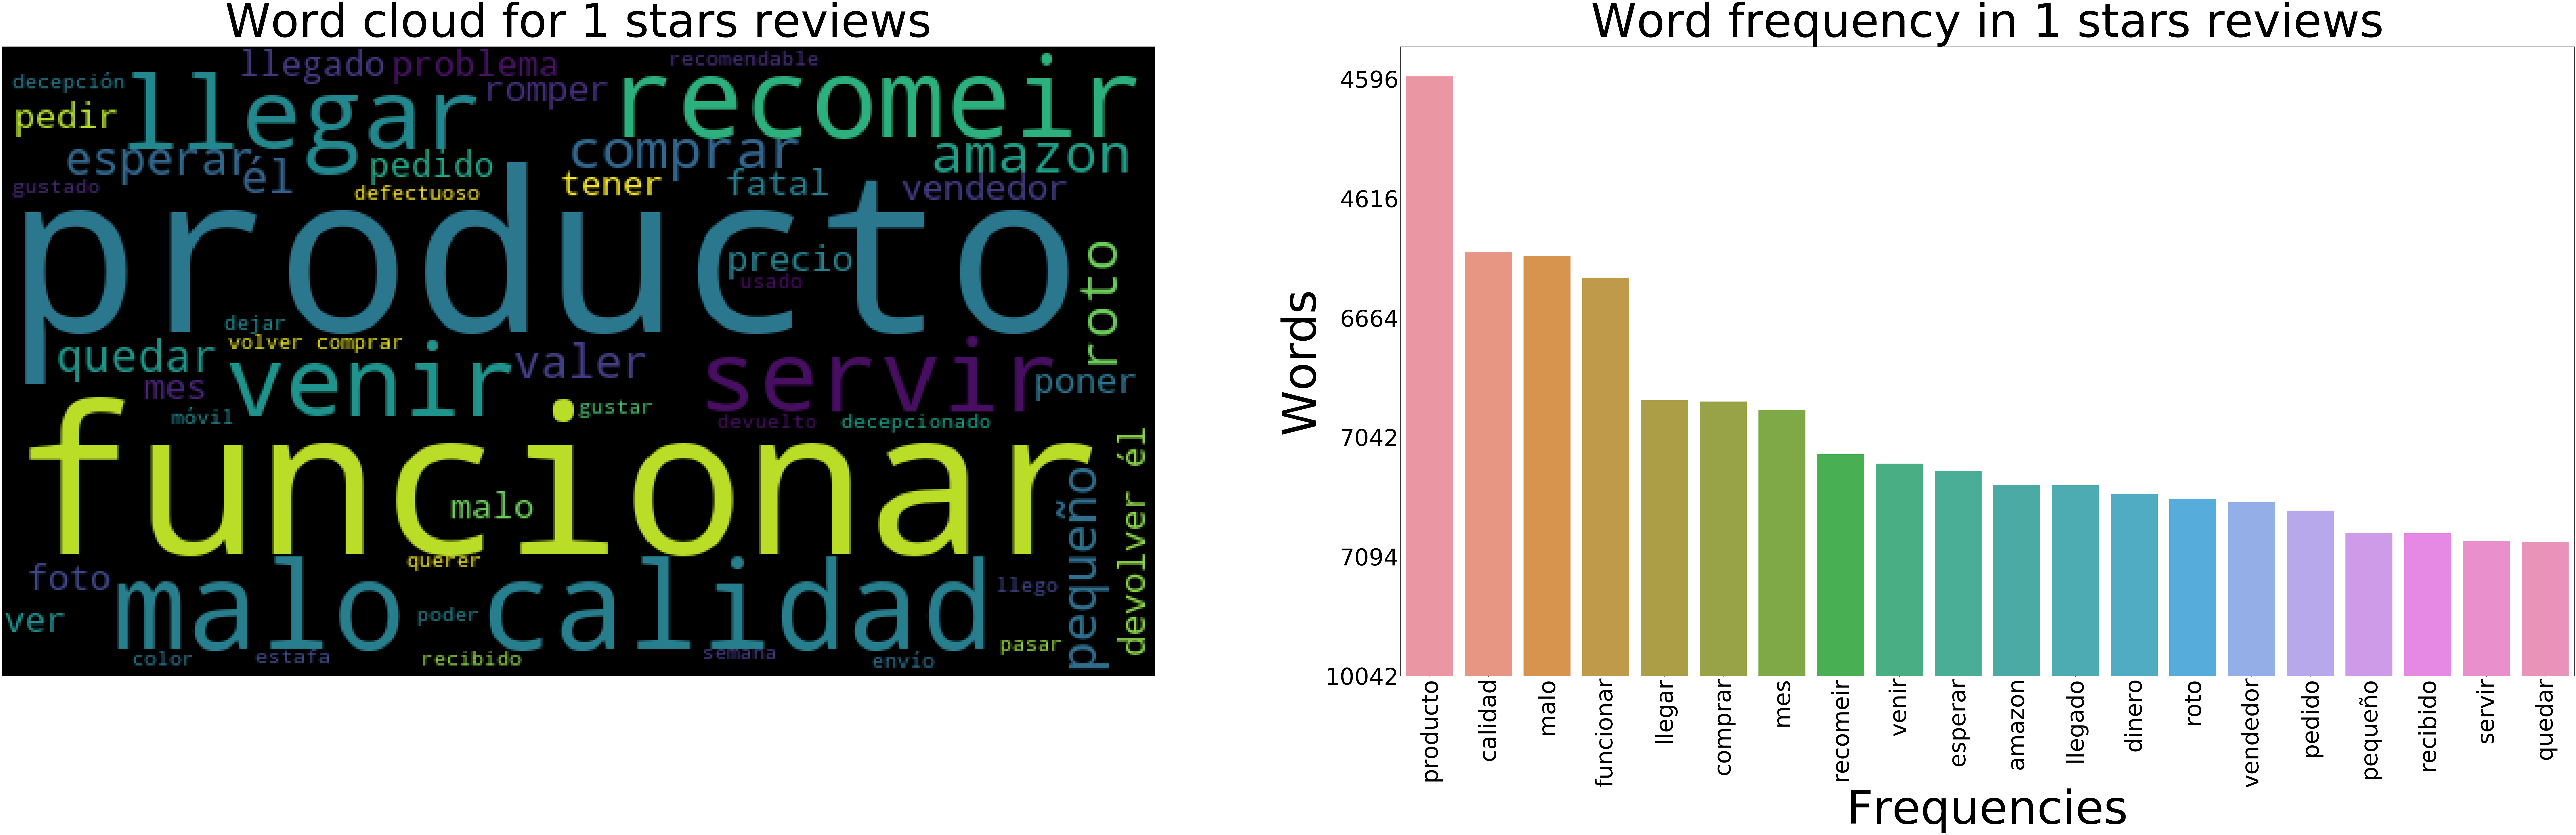

-------------
5 most common words for 2 star reviews
       Words  Frequency
0    calidad       9323
1   producto       6158
2  funcionar       4717
3    pequeño       4591
4       malo       4591
-------------


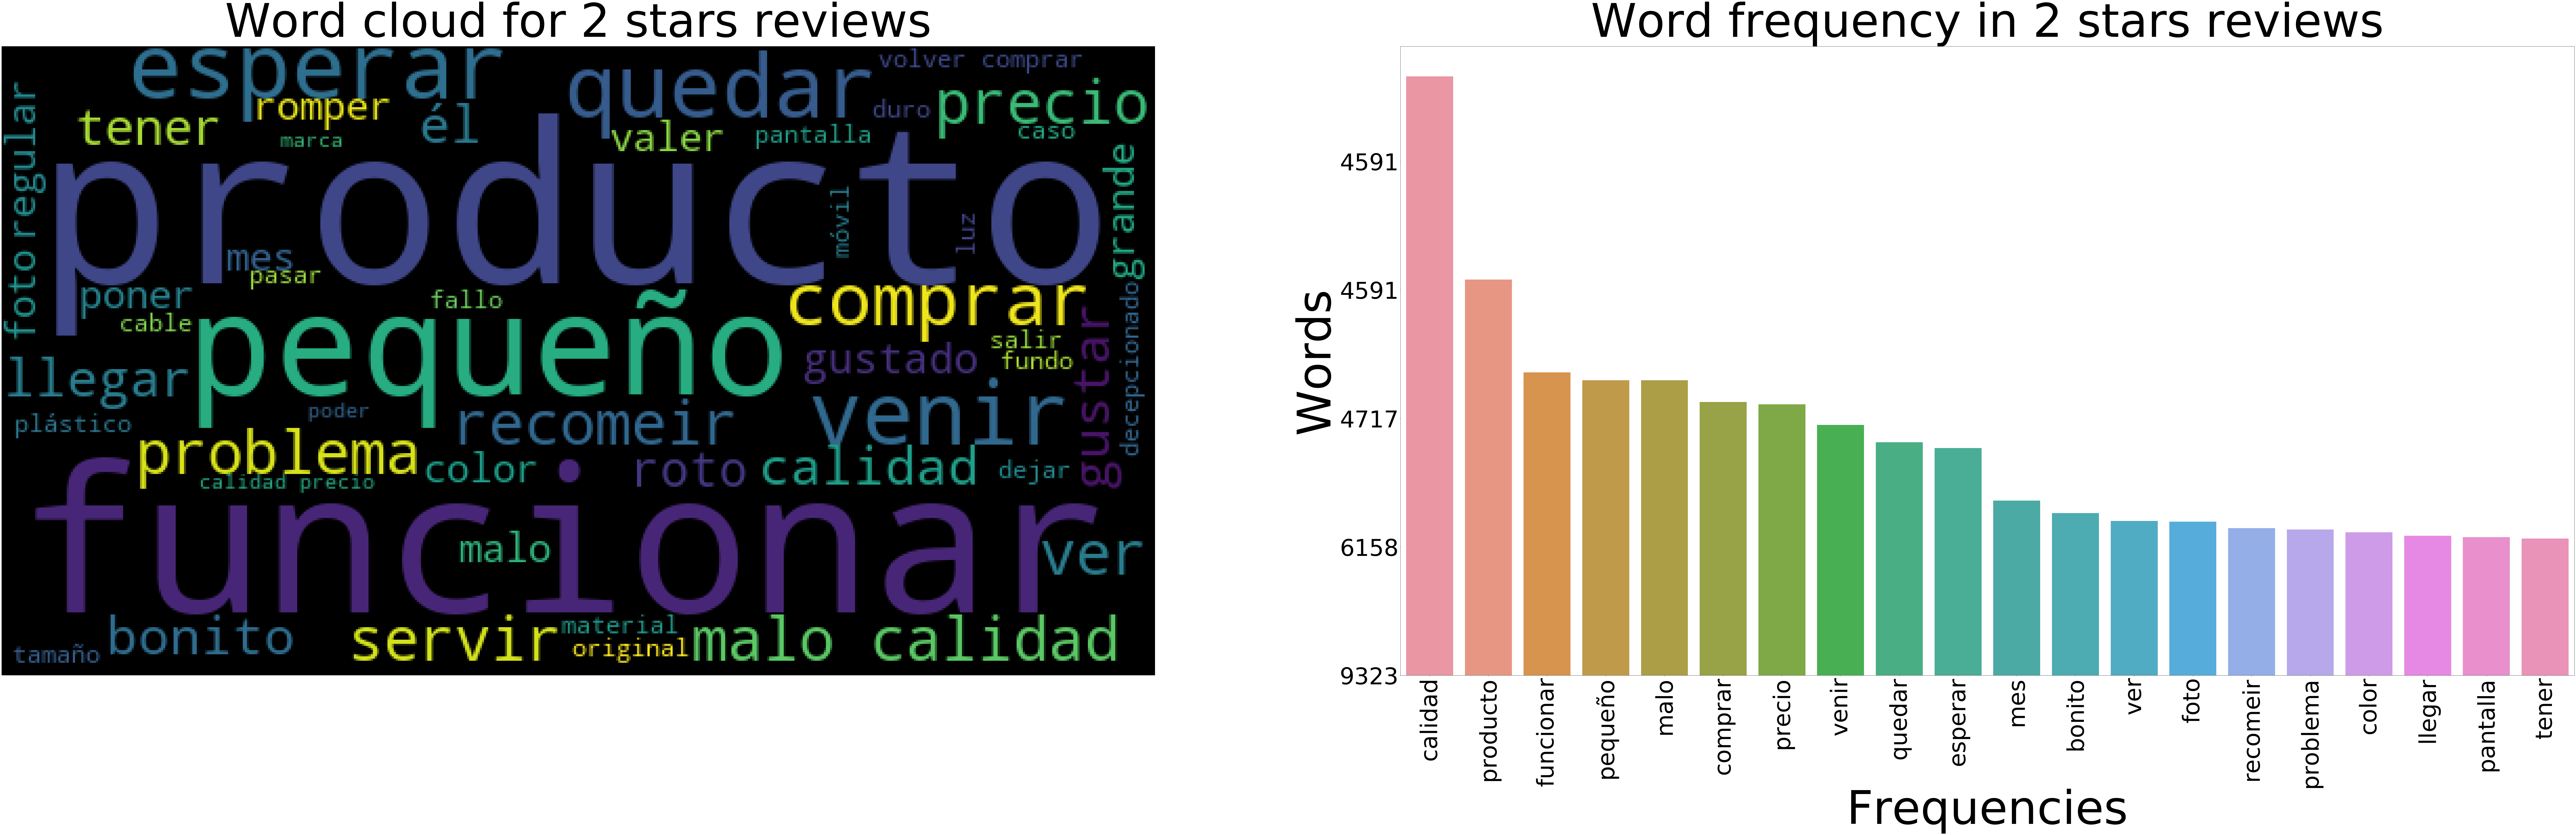

-------------
5 most common words for 3 star reviews
      Words  Frequency
0   calidad       8975
1    precio       7709
2  producto       5494
3   pequeño       4967
4   esperar       3608
-------------


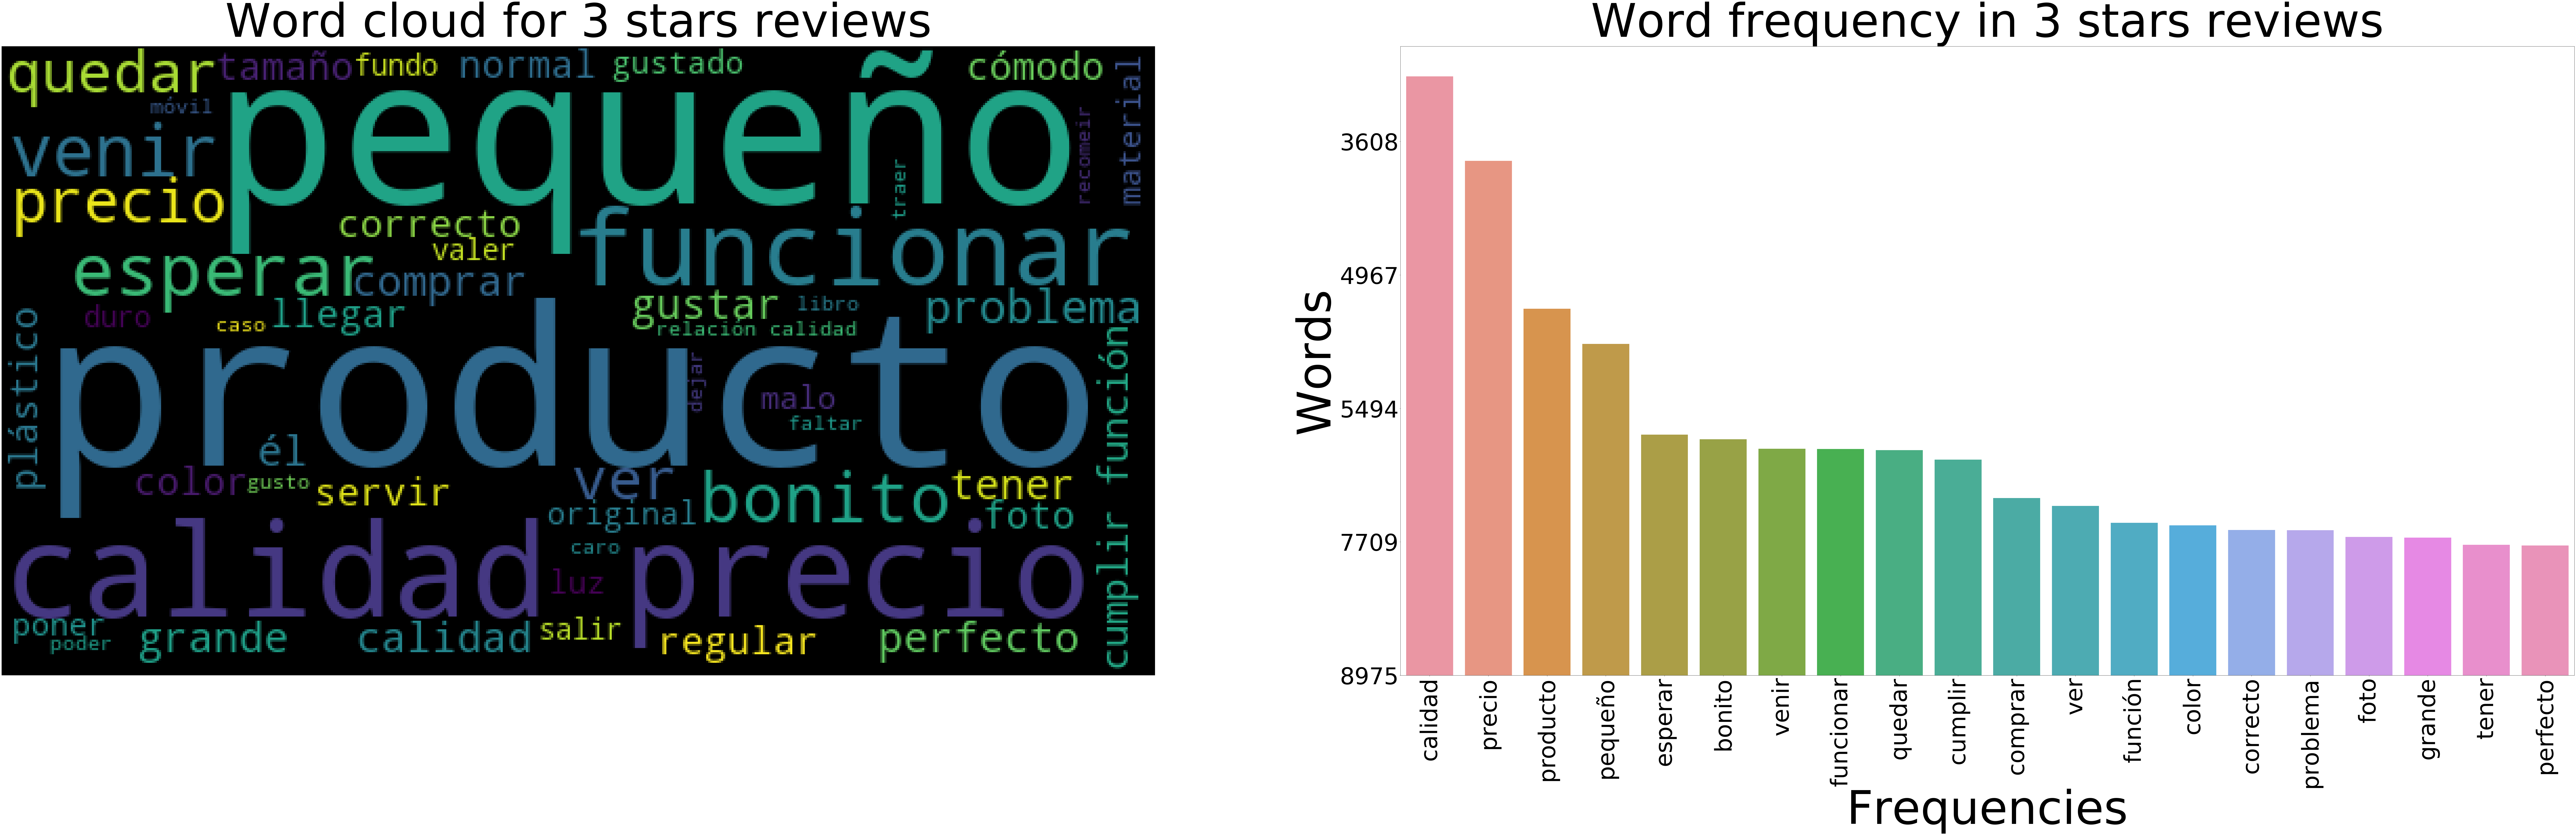

-------------
5 most common words for 4 star reviews
      Words  Frequency
0   calidad      11928
1    precio      11050
2  producto       6728
3  perfecto       5371
4   cumplir       4862
-------------


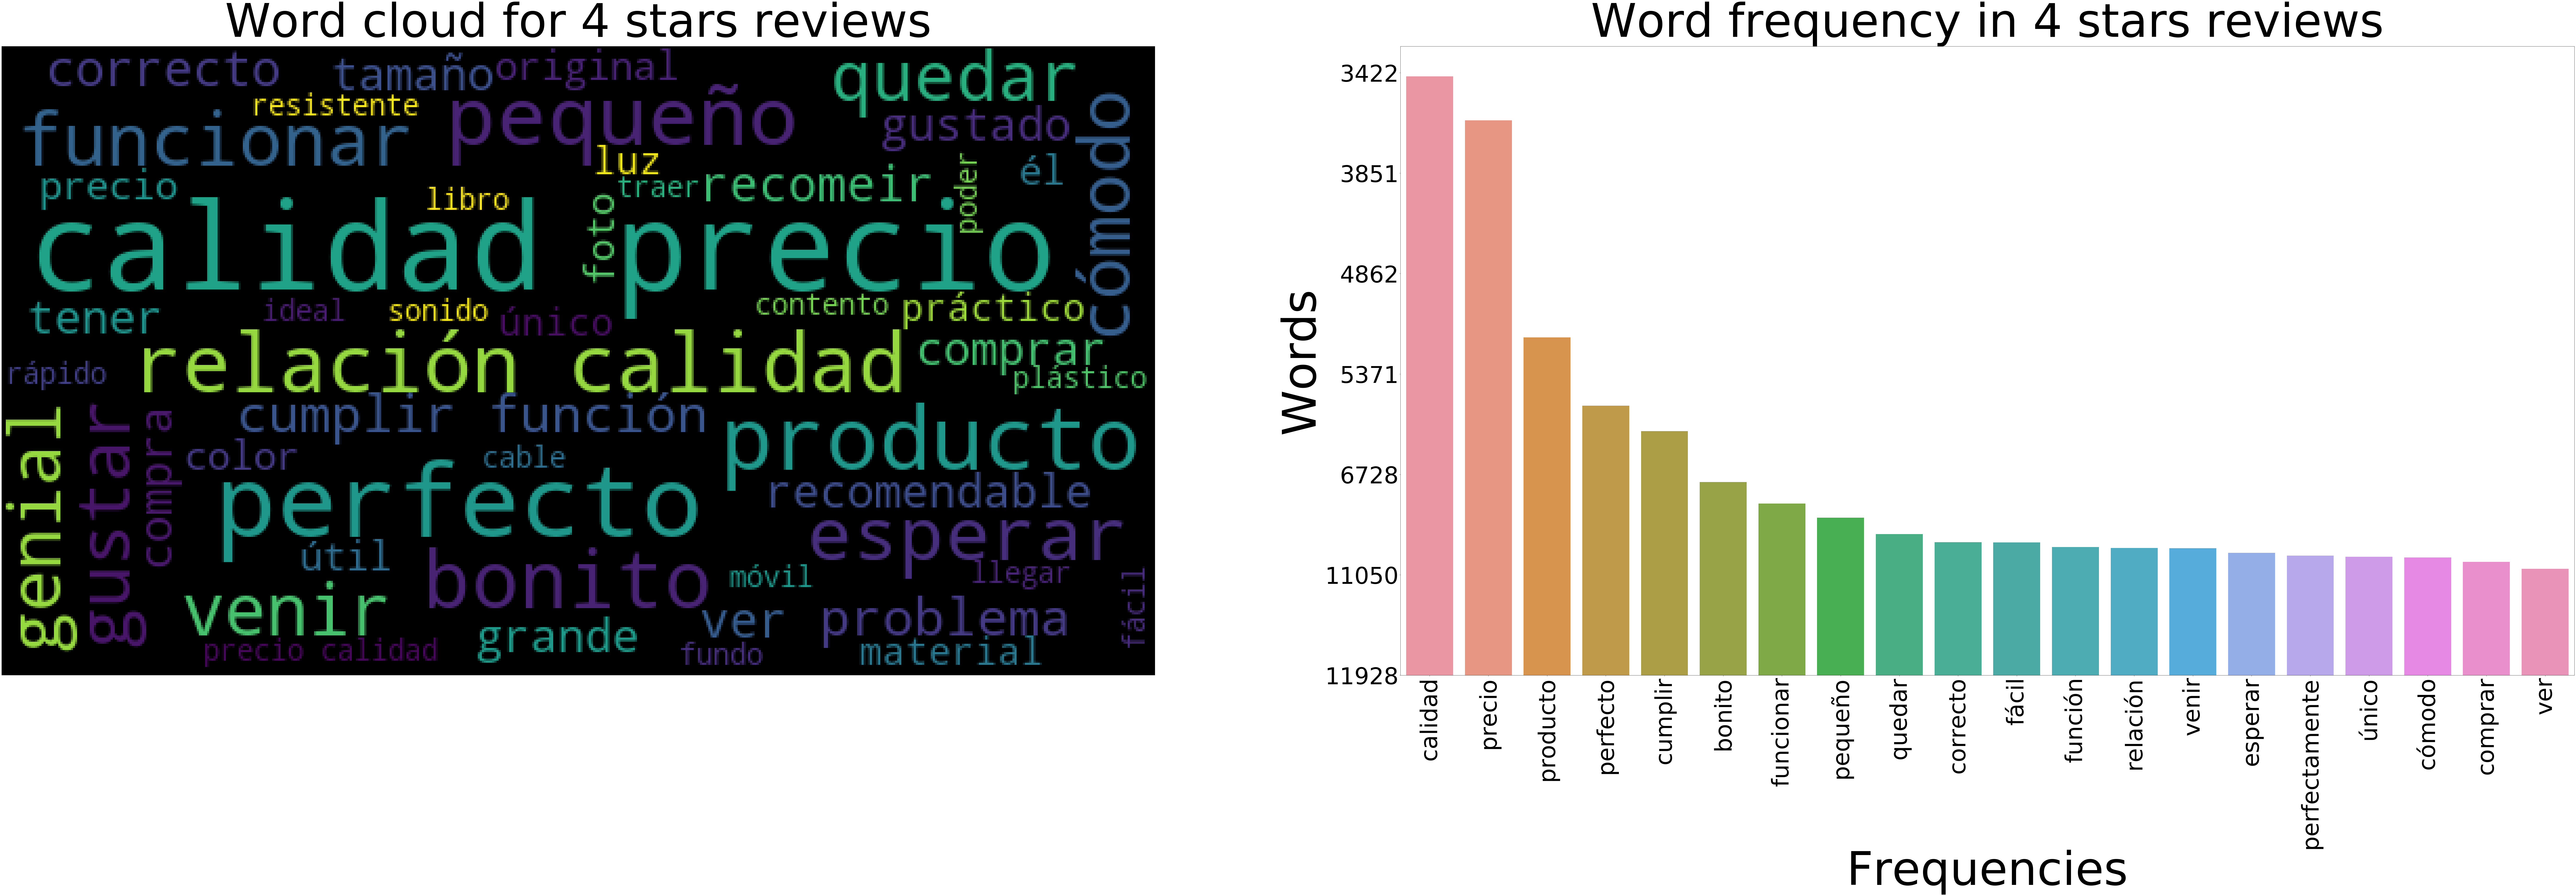

-------------
5 most common words for 5 star reviews
      Words  Frequency
0   calidad      12779
1  perfecto      11312
2    precio       8667
3  producto       6920
4    genial       4083
-------------


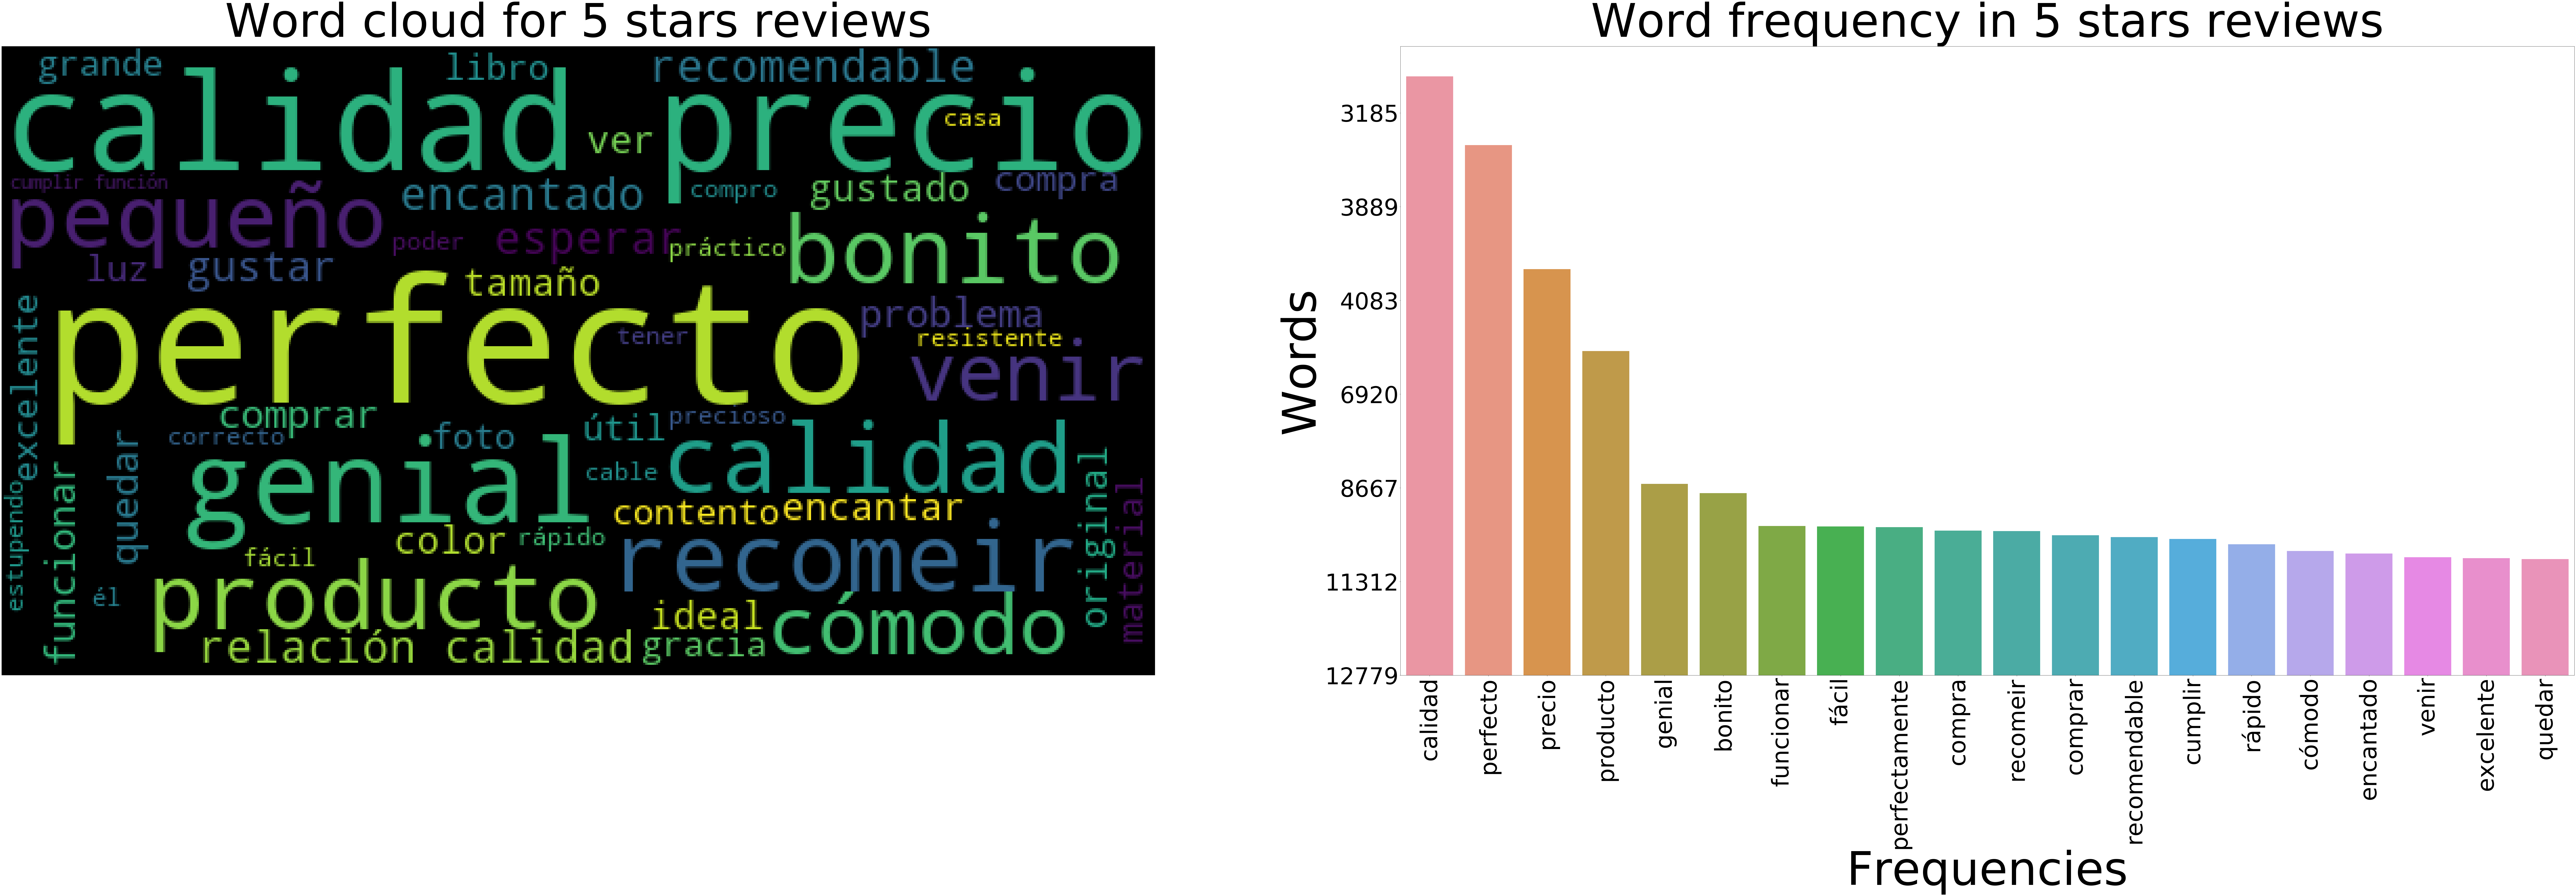

-------------


In [28]:
for x in range(1,6):
    tokenized_df = df_amazon[df_amazon['stars']==x]
    tokenized_list = tokenized_df.full_review_tk.tolist()

    list_tk = [x for l in tokenized_list for x in l]

    word_frequency = Counter(list_tk)
    common_words = word_frequency.most_common()
    
    print(f'5 most common words for {x} star reviews')
    df_freq = pd.DataFrame(common_words, columns = ['Words', 'Frequency'])
    print(df_freq.head(5))
    print('-------------')
    
    size_plots = (200,50)
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=size_plots)
    ax1 = plt.subplot(121)
    u_string=(" ").join(list_tk)
    wc = WordCloud(max_words = 50,width=size_plots[0]+350,height=size_plots[1]+250).generate(u_string)
    ax1.imshow(wc)
    ax1.axis("off")
    ax1.set_title(f'Word cloud for {x} stars reviews', fontsize=200)

    ax2 = plt.subplot(122)
    ax2 = sns.barplot(ax=ax2,x = df_freq.iloc[:20].Words, y = df_freq.iloc[:20].Frequency)
    ax2.set_xticklabels(df_freq.iloc[:20].Words,fontsize = 100,rotation=90)
    ax2.set_yticklabels(df_freq.iloc[:20].Frequency,fontsize = 100)
    ax2.set_ylabel('Words',fontsize=200)
    ax2.set_xlabel('Frequencies',fontsize=200)
    ax2.figure.set_size_inches(size_plots[0],size_plots[1])
    ax2.set_title(f'Word frequency in {x} stars reviews',fontsize=200)
    ax2.axis("on")
    plt.show()    
    
    print('-------------')

# 3. Machine Learning

## Scope

In this section, firstly, I will vectorize the entire dataset to be able to work with ML models.

Then, 2 models (`LinearSVC` and `Random Forest`) will be trained to predict the prices of the properties present in the dataset, they will be compared with a benchmark model (`Naive Bayes`), their hyperparameters will be optimized to reduce the error and finally an analysis will be carried out on the methodology proposal

## Metric selection
In the first place, it should be clarified that the problem is about classifying short texts in 5 rating scales, taking a review as input and returning from it a prediction about what the score will be given by the user for the purchase made. It is, then, a case of **`classification`**.

As can be seen in cell 8, there are the same number of reviews for each star level, which implies that the dataset is perfectly balanced. For this type of case, it is usually recommended to use the metric **`Accuracy`**.

In addition, I will also graph the **`Confusion Matrix`** of each model to be able to visualize how the different models classify the comments of different scales.

## Transformations

I will work with the datasets provided initially. These are:
- **`df`**
- **`df_test`**
- **`df_train`**

In [29]:
df = pd.read_json('dataset_es_dev.json',lines=True)
df_test = pd.read_json('dataset_es_test.json',lines=True)
df_train = pd.read_json('dataset_es_train.json',lines=True)

To facilitate data processing, I will join the reviews with their titles in the same column (`full_review`), making the text lower case, eliminating the `review_body` and `review_title` attributes containing this information separately and discarding all other columns

In [30]:
df['full_review'] = df['review_title'] + ' ' + df['review_body']
df['full_review'] = df['full_review'].str.lower()
df = df.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id','product_category', 'review_body', 'review_title'])

df_test['full_review'] = df_test['review_title'] + ' ' + df_test['review_body']
df_test['full_review'] = df_test['full_review'].str.lower()
df_test = df_test.drop(columns=['language', 'review_id', 'product_id','product_category', 'reviewer_id', 'review_body', 'review_title'])

df_train['full_review'] = df_train['review_title'] + ' ' + df_train['review_body']
df_train['full_review'] = df_train['full_review'].str.lower()
df_train = df_train.drop(columns=['language', 'review_id', 'product_id','product_category', 'reviewer_id', 'review_body', 'review_title'])

In [31]:
df_train.head(5)

stars                                        full_review
0      1  television nevir nada bueno se me fue ka panta...
1      1  dinero tirado a la basura con esta compra horr...
2      1  solo llega una unidad cuando te obligan a comp...
3      1  producto no recibido. no entro en descalificar...
4      1      devuelto llega tarde y co la talla equivocada

I apply the processing to the 3 dataframes separately

In [32]:
df['full_review_tk'] = df.apply(lambda row: process(row['full_review']), axis=1)
df_test['full_review_tk'] = df_test.apply(lambda row: process(row['full_review']), axis=1)
df_train['full_review_tk'] = df_train.apply(lambda row: process(row['full_review']), axis=1)

I will save the results again in **`.xlsx`** files as a checkpoint

In [33]:
df.to_excel('ml_df.xlsx')
df_test.to_excel('ml_df_test.xlsx')
df_train.to_excel('ml_df_train.xlsx')

In [34]:
df.head(5)

stars                                        full_review  \
0      1  mala compra malisimo, muy grande demasiado apa...   
1      1  no lo he recibido no he recibido el pedido no ...   
2      1  que no aprieta bien en el manillar tengo que b...   
3      1  brocas de mantequilla utilicé las brocas de me...   
4      1  no me gusta no me gusta su olor a viejo y aspe...   

                                      full_review_tk  
0  [malo, compra, malisimo, grande, aparatoso, pr...  
1           [recibido, recibido, pedido, devolución]  
2  [aprieta, manillar, buscar, sistema, funcionar...  
3  [broca, mantequillar, utilicé, broca, menor, d...  
4        [gustar, gusta, olor, viejo, aspecto, malo]

In [35]:
df['full_review_tk'] = df['full_review_tk'].apply(str)
df_test['full_review_tk'] = df_test['full_review'].apply(str)
df_train['full_review_tk'] = df_train['full_review'].apply(str)

In [36]:
df.head(4)

stars                                        full_review  \
0      1  mala compra malisimo, muy grande demasiado apa...   
1      1  no lo he recibido no he recibido el pedido no ...   
2      1  que no aprieta bien en el manillar tengo que b...   
3      1  brocas de mantequilla utilicé las brocas de me...   

                                      full_review_tk  
0  ['malo', 'compra', 'malisimo', 'grande', 'apar...  
1   ['recibido', 'recibido', 'pedido', 'devolución']  
2  ['aprieta', 'manillar', 'buscar', 'sistema', '...  
3  ['broca', 'mantequillar', 'utilicé', 'broca', ...

## Data vectorization

I'll then vectorize the text through the weighting factor **`Tf-idf`**. This determines the relevance of a word from the frequency with which it appears in a document present in a collection of documents.

By taking into account the *inverse* frequency within the document collection, this weighting can attenuate the effect of some words being more common in the document collection. Thus, in a collection of reviews about, for example, infusions, the weight will reduce the weight of the word "coffee" as it is to be expected to be a frequent word in the collection of reviews.

A high weight in **`Tf-idf`** is achieved with a high frequency of term (in the given review) and a small frequency of occurrence of the term in the entire collection of reviews

In [37]:
review_list_test = list(df_test['full_review_tk'].values)
test_score = df_test['stars'].values

review_list_train = list(df_train['full_review_tk'].values)
train_score = df_train['stars'].values 

review_list = list(df['full_review_tk'].values)
score = df['stars'].values 

# TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,1),max_features=1000, min_df=30)

# Compute the word counts, idf and tf-idf values all at once
review_matrix_test= tfidf.fit_transform(review_list_test)
review_matrix_train = tfidf.transform(review_list_train)
review_matrix = tfidf.transform(review_list)

print('Train', review_matrix_train.shape)
print('Test', review_matrix_test.shape)
print('Data', review_matrix.shape)

Train (200000, 524)
Test (5000, 524)
Data (5000, 524)


In [39]:
review_matrix_train = review_matrix_train.astype('float32')
train_score = train_score.astype('int8')

review_matrix_test = review_matrix_test.astype('float32')
test_score= test_score.astype('int8')

review_matrix = review_matrix.astype('float32')
score= score.astype('int8')

In [42]:
#TRAIN
X_train = review_matrix_train.toarray()
y_train = train_score

#TEST
X_test = review_matrix_test.toarray()
y_test = test_score

#DATA
X = review_matrix.toarray()
y = score

## Model training

I will then train a Naive-Bayes model and consider it benchmark to compare its performance with two other classification models

In [43]:
nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

I test different ML models to compare their performance

In [44]:
random_forest = RandomForestClassifier(max_depth=50, 
                                       random_state=50)
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [45]:
svc = LinearSVC(C = 1, random_state=50)
svc.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=50, tol=0.0001,
          verbose=0)

## Predictions and results

In [46]:
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))

Accuracy train NB:  0.45098
Accuracy test NB:  0.4518


In [47]:
y_train_pred_rf = random_forest.predict(X_train)
y_test_pred_rf = random_forest.predict(X_test)

print("Accuracy train Random Forest: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test Random Forest: ", accuracy_score(y_test, y_test_pred_rf))

Accuracy train Random Forest:  0.947195
Accuracy test Random Forest:  0.5032


In [48]:
y_train_pred_svc= svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

print("Accuracy train LinearSVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test LinearSVC: ", accuracy_score(y_test, y_test_pred_svc))

Accuracy train LinearSVC:  0.525995
Accuracy test LinearSVC:  0.5252


The model with the highest test accuracy is `LinearSVC`. The fact that Random Forest presents a significantly greater precision on the *training* dataset but not on the *test* one reveals that it does present **overfitting**

Next, I will plot the confusion matrices for the selected models

Model: Naive-Bayes


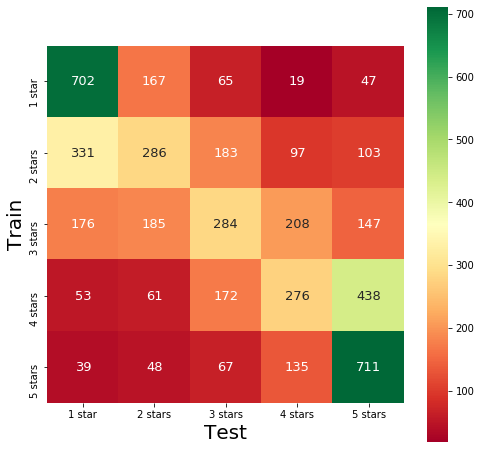

Model: Random Forest


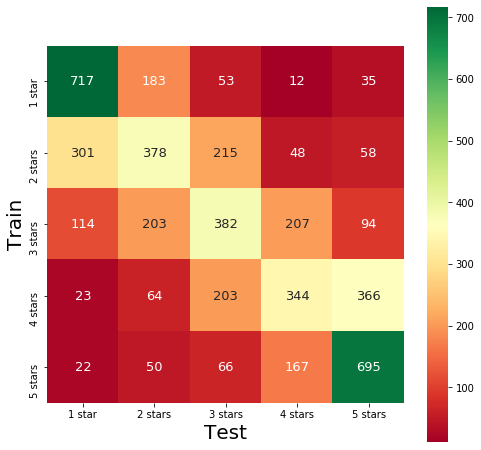

Model: SVC


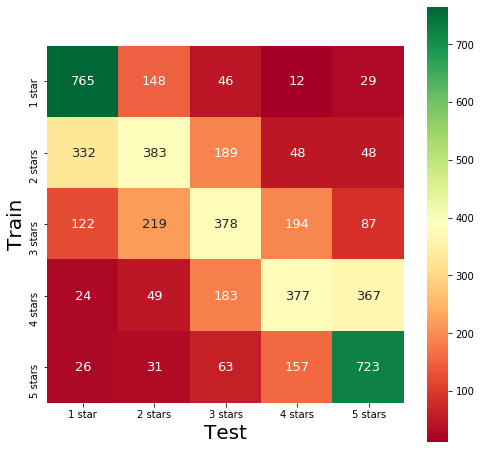

In [65]:
list_models = ([y_test_pred,'Naive-Bayes'],[y_test_pred_rf,'Random Forest'],[y_test_pred_svc,'SVC'])

for i in range(0,3):
    print('Model: '+list_models[i][1])
    stars=["1 star","2 stars", "3 stars", "4 stars", "5 stars"]
    cm = confusion_matrix(y_test,list_models[i][0])
    f,ax = plt.subplots(figsize=(8,8))
    sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

    plt.xlabel("Test", size =20)
    plt.ylabel("Train", size =20)
    ax.set_xticklabels(stars)
    ax.set_yticklabels(stars)
    plt.show()

### Conclusions

From these results I can conclude that `Random Forest` is the best model to predict intermediate scores (**3 stars**), while the other 2 have more precision in the reviews with a more marked trend (**1 or 5 stars**).

However, precision is slightly better in `LinearSVC`, in addition to `Random Forest` there is overfitting, so the best model is still first. We can also observe that the `LinearSVC` model practically confuses 4-star reviews with 5-star ones.

The difficulty in differentiating reviews that are not at the extreme of scores can be corroborated in the word clouds, where most of the words used are common for reviews between 2 and 4 stars, while in the most extreme they present particular words , such as *malo* [eng: bad] or *excelente* [eng: excellent].

## Optimization

A first look at the way in which the data is treated allows us to observe that when vectorizing, the `Tf-idf` weighting only takes into account the words in unigrams, that is, one at a time. (via the hyperparameter **`ngram_range = (1,1)`**).

The performance of the models could be significantly improved by taking up to trios of words, or *trigrams* since they can capture more complex expressions such as *muy buena calidad* [eng: very good quality], instead of *muy* [eng: very], *buena* [eng: good] and *calidad* [eng: quality] separately, since, without context, the words "very" and "quality" can be neutral, while the expression as a whole can be a very good predictor of a 5-star score.

In [51]:
list_reviews_test2 = list(df_test['full_review_tk'].values)
score_test2 = df_test['stars'].values

list_reviews_train2 = list(df_train['full_review_tk'].values)
score_train2 = df_train['stars'].values 

list_reviews2 = list(df['full_review_tk'].values)
score2 = df['stars'].values 

#TfidfVectorizer
tfidf2 = TfidfVectorizer(ngram_range=(1, 3), max_features=1000, min_df=30)

# Compute the word counts, idf and tf-idf values all at once
review_matrix_test2= tfidf2.fit_transform(list_reviews_test2)
review_matrix_train2 = tfidf2.transform(list_reviews_train2)
review_matrix2 = tfidf2.transform(list_reviews2)

print('Train', review_matrix_train2.shape)
print('Test', review_matrix_test2.shape)
print('Data', review_matrix2.shape)

Train (200000, 957)
Test (5000, 957)
Data (5000, 957)


In [52]:
review_matrix_train2 = review_matrix_train2.astype('float32')
score_train2 = score_train2.astype('int8')

review_matrix_test2 = review_matrix_test2.astype('float32')
score_test2= score_test2.astype('int8')

In [53]:
# Train set
X_train2 = review_matrix_train2.toarray()
y_train2 = score_train2

# Test set
X_test2 = review_matrix_test2.toarray()
y_test2 = score_test2

In [54]:
# Retrain all three models

nb.fit(X_train2,y_train2)
y_train_pred2 = nb.predict(X_train2)
y_test_pred2 = nb.predict(X_test2)

random_forest.fit(X_train2,y_train2)
y_train_pred_rf2 = random_forest.predict(X_train2)
y_test_pred_rf2 = random_forest.predict(X_test2)

svc.fit(X_train2, y_train2)
y_train_pred_svc2= svc.predict(X_train2)
y_test_pred_svc2 = svc.predict(X_test2)

In [55]:
# Reprint results
print('Tf-idf unigrama')
print("Accuracy train NB: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test NB: ", accuracy_score(y_test, y_test_pred))
print('--------------------------')
print("Accuracy train RF: ", accuracy_score(y_train, y_train_pred_rf))
print("Accuracy test RF: ", accuracy_score(y_test, y_test_pred_rf))
print('--------------------------')
print("Accuracy train SVC: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test SVC: ", accuracy_score(y_test, y_test_pred_svc))
print(" ")

print('Tf-idf trigrama')
print("Accuracy train NB: ", accuracy_score(y_train2, y_train_pred2))
print("Accuracy test NB: ", accuracy_score(y_test2, y_test_pred2))
print('--------------------------')
print("Accuracy train RF: ", accuracy_score(y_train2, y_train_pred_rf2))
print("Accuracy test RF: ", accuracy_score(y_test2, y_test_pred_rf2))
print('--------------------------')
print("Accuracy train LinearSVC: ", accuracy_score(y_train2, y_train_pred_svc2))
print("Accuracy test LinearSVC: ", accuracy_score(y_test2, y_test_pred_svc2))

Tf-idf unigrama
Accuracy train NB:  0.45098
Accuracy test NB:  0.4518
--------------------------
Accuracy train RF:  0.947195
Accuracy test RF:  0.5032
--------------------------
Accuracy train SVC:  0.525995
Accuracy test SVC:  0.5252
 
Tf-idf trigrama
Accuracy train NB:  0.48041
Accuracy test NB:  0.4796
--------------------------
Accuracy train RF:  0.92222
Accuracy test RF:  0.5066
--------------------------
Accuracy train LinearSVC:  0.54273
Accuracy test LinearSVC:  0.5316


We can see that the improvement is marginal, so I will try to use the hyperparameter optimization of the best performance model (**`LinearSVC`**) using **`GridsearchCV`**, in the which tests all the possible combinations of the dictionary that I pass through the variable `parameters`

In [56]:
X_train_tfidfopt = X_train2.copy()
y_train_tfidfopt = y_train2.copy()
X_test_tfidfopt = X_train2.copy()
y_test_tfidfopt = y_train2.copy()

In [57]:
svc_opt = LinearSVC() 

parameters =  {'C': [0.001, 10, 25, 100, 500],
                'penalty':['l1','l2'],
                'tol': [1e-2, 1e-4],
                'loss': ['hinge', 'squared_hinge']}              


CV_svc = GridSearchCV(estimator=svc_opt, param_grid=parameters, cv= 2)
CV_svc.fit(X_train_tfidfopt, y_train_tfidfopt)
print(CV_svc.best_params_)

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

{'C': 10, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.01}


We then input the optimized hyperparameters obtained in previous cell to check if there was an improvement in the accuracy of the model

In [58]:
svc_opt = LinearSVC(C=10,loss='squared_hinge',penalty='l2',tol = 0.01) 

svc_opt.fit(X_train_tfidfopt, y_train_tfidfopt)

y_train_pred_opt = svc_opt.predict(X_train_tfidfopt)
y_test_pred_opt = svc_opt.predict(X_test_tfidfopt)

print("Accuracy train LinearSVC no optimization: ", accuracy_score(y_train, y_train_pred_svc))
print("Accuracy test LinearSVC: no optimization", accuracy_score(y_test, y_test_pred_svc),'\n')

print('--------------\n')

print("Accuracy train LinearSVC optimized: ", accuracy_score(y_train_tfidfopt, y_train_pred_opt))
print("Accuracy test LinearSVC: optimized", accuracy_score(y_test_tfidfopt, y_test_pred_opt))

Accuracy train LinearSVC no optimization:  0.525995
Accuracy test LinearSVC: no optimization 0.5252 

--------------

Accuracy train LinearSVC optimized:  0.542755
Accuracy test LinearSVC: optimized 0.542755


As we can see, there is no major gain with the optimized hyperparameters obtained for this model.

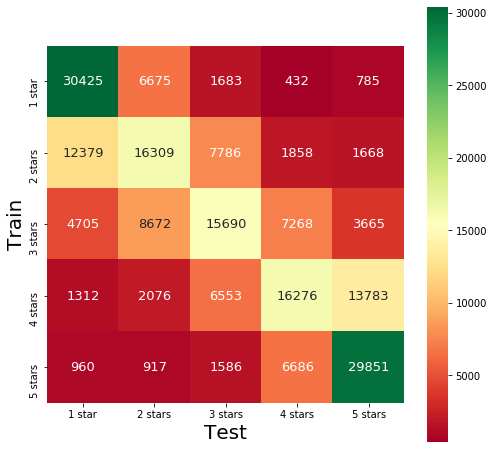

In [59]:
rating = ["1 star","2 stars", "3 stars", "4 stars", "5 stars"]
cm = confusion_matrix(y_test_tfidfopt,y_test_pred_opt)
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

plt.xlabel("Test", size =20)
plt.ylabel("Train", size =20)
ax.set_xticklabels(rating)
ax.set_yticklabels(rating)
plt.show()

Finally, and to better visualize the 3-star words or phrases whose presence or absence defines the classification in the different ranges, I will graph the importance of each one:

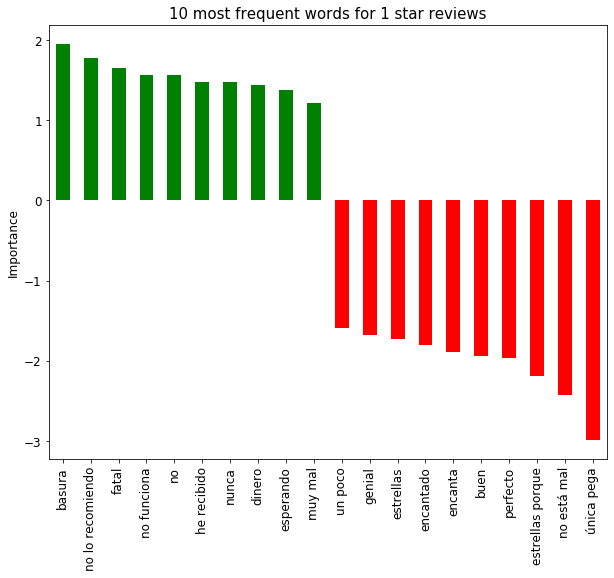

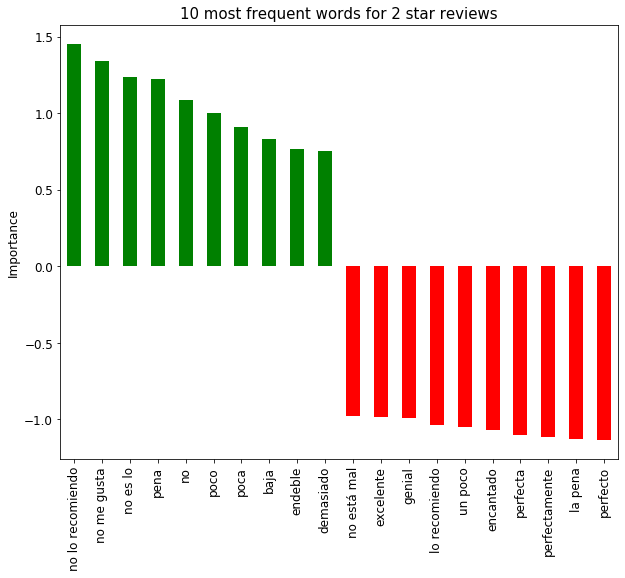

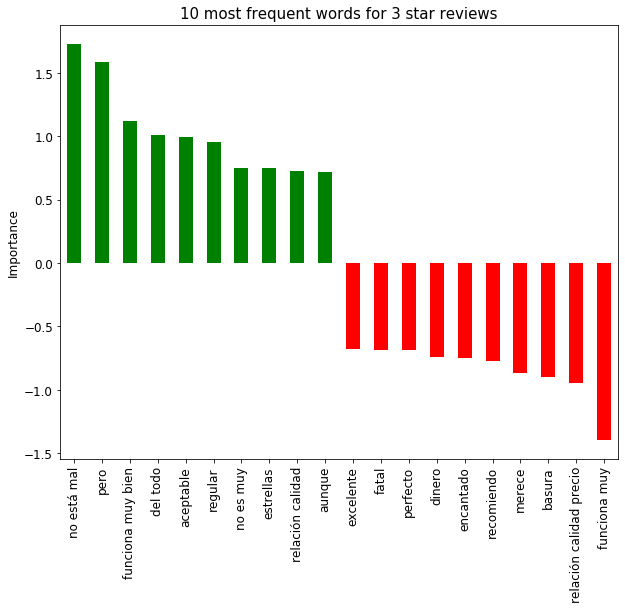

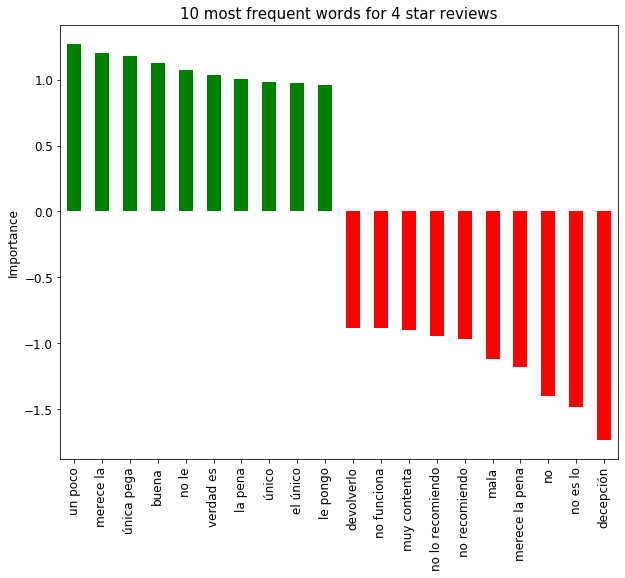

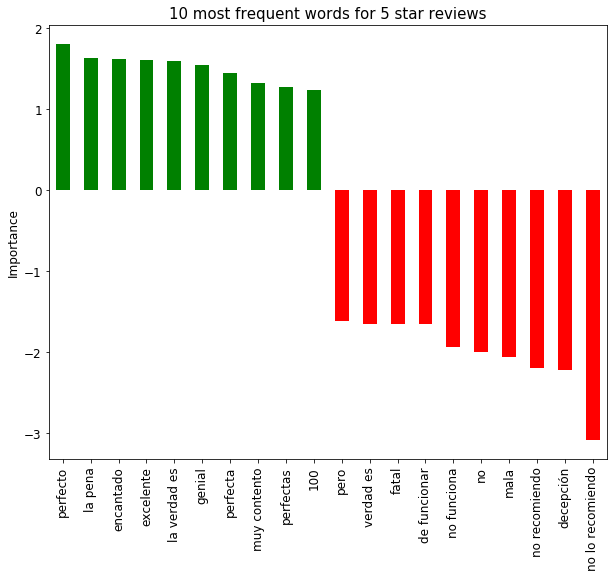

In [60]:
all_words = tfidf2.get_feature_names()

for x in range (0,5):
    coef = list(svc_opt.coef_[x])
    label = list(all_words)
    words = pd.DataFrame()
    words['Features'] = label
    words['Importance'] = coef
    features = words.reset_index(drop=True)
    sorted_words = features.sort_values(by=['Importance'], ascending=False)
    sorted_words = sorted_words.reset_index(drop=True)
    data_plot = pd.concat([sorted_words.head(10), sorted_words.tail(10)])
    data_plot.sort_values(by=['Importance'], ascending=False, inplace = True)
    data_plot['positive'] = data_plot['Importance'] > 0
    data_plot.set_index('Features', inplace = True)
    data_plot.Importance.plot(kind='bar', figsize = (10,8),
                              color = data_plot.positive.map({True: 'green', False: 'red'}),
                              fontsize=12)
    plt.xlabel ('', fontsize=12)
    plt.ylabel ('Importance', rotation = 90, fontsize=12)
    plt.title ('10 most frequent words for ' + str(x+1) + ' star reviews', fontsize=15)
    plt.show()

# 4. Conclusions

We can conclude that the performance improved very little both with the Tf-idf tuning and with the hyperparameter optimization of the `LinearSVC` model. From the confusion matrix we see that the ability to predict 4 stars improved a bit to almost match the performance of 2 stars, as opposed to the non-optimized one. Reviews of intermediate scores will mark the roof of the model's performance, and beyond rigorous optimization the gains from a certain point will be marginal.

There will always be a limit to the ability of a Machine Learning model to classify scores on a scale of 1 to 5. This is due to an inherent limitation of the language due to the lack of distinctive words in intermediate reviews and because they tend to have as many words bad as good. Below, I'll print 3 random reviews of 2, 3, and 4-star scores to demonstrate the difficulty of distinguishing them with the naked eye.

In [61]:
for i in range(2,5):
    df1 = df.loc[df['stars']==i]
    indice_min = min(df1.index)
    indice_max = max(df1.index)
    print(f'3 {i} stars reviews:')
    for x in range(1,4):
        print(df1['full_review'].loc[df['stars']==i][random.randint(indice_min,indice_max)])
    print('----------------')

3 2 stars reviews:
peor de lo que esperaba la talla es la esperada, pero tiene un olor que no se va después de varios lavados y no es precisamente bueno, sino todo lo contrario... relación calidad precio mala.
bien esta bien lo esperaba más grande pero esta bien
bien pero lo pega mucho no pega muy bien, al desenchufar se queda junto al cabezal del cable y tengo que volver a ponerlo
----------------
3 3 stars reviews:
mejorable muy caro para los materiales.
precio bajo duración baja precio bajo, duración baja
un día después la entrega tardo en llegar un día más de lo que me habían dicho.
----------------
3 4 stars reviews:
buena relacion calidad-precio facil de hinchar y grande para niños
servicio y rapidez en la entrega me la recomendaron y efectivamente va muy bien.
rapidez y buena presentacion igual que me esperaba muy contenta, perfecto para regalar
----------------


Beyond this, the classification of the reviews in 5 classes, depending on the use of this information, could be trivial, since knowing if a product has 2 or 3 stars would not provide any valuable and actionable information. Converting this problem to a *binary* (positive / negative) classification might be more practical and at the same time would greatly improve model performance.

This could allow in the future to replace the rating + review system with one that only allows reviewing, which could avoid the bias in the granting of scores, since each user has a personal subjective concept of what they would consider to be 2 or 4 stars.

I would like to be able to test other models and with more hyperparameter variations, but I find hardware limitations does not allow me to perform all the tests I want at the speed I need due to lack of processing capacity.

As an experiment and to test the quality of the model first hand, I will write 10 fictitious reviews about buying a TV that start with "I bought this TV and ..." to be evaluated and see if the predictions match the score that I assumed in advance that they deserved

English translations of each review will be given below:

| Spanish | English |
| :- | :- |
| Compré este televisor y sinceramente no lo recomiendo, la definición me resulta horrible | I bought this TV and I honestly do not recommend it, the definition is horrible to me |
| Compré este televisor y me encantó | I bought this TV and I loved it |
| Compré este televisor y la calidad de la imagen es mala | I bought this TV and the picture quality is bad |
| Compré este televisor y me resulta muy bueno. Como punto a mejorar, me gustaría que los soportes no estén hechos de plástico porque me da miedo que se rompan | I bought this TV and I find it very good. As a point to improve, I would like that the supports are not made of plastic because I am afraid that they will break |
| Compré este televisor y la relación calidad precio es buena pero no me termina de convencer del todo | I bought this TV and the price-quality ratio is good but it doesn't quite convince me |
| Compré este televisor y pareció una basura | I bought this TV and it looked like rubbish |
| Compré este televisor y es muy feo. Rescato su nitidez pero me resulta muy pesado y aparatoso | I bought this TV and it is very ugly. Its sharpness is somewhat good but I find it very heavy and bulky |
| Compré este televisor y su única pega es el precio | I bought this TV and its only downside is the price |
| Compré este televisor y la calidad podría ser mejor | I bought this TV and the quality could be better |
| Compré este televisor y me siento un poco decepcionado porque algunos botones fallan pero la calidad es dentro de todo decente | I bought this TV and I am a little disappointed that some buttons are missing but the quality is decent at all |

In [64]:
review = ['Compré este televisor y sinceramente no lo recomiendo, la definición me resulta horrible',
         'Compré este televisor y me encantó',
          'Compré este televisor y la calidad de la imagen es mala',
          'Compré este televisor y me resulta muy bueno. Como punto a mejorar, me gustaría que los soportes no estén hechos de plástico porque me da miedo que se rompan',
         'Compré este televisor y la relación calidad precio es buena pero no me termina de convencer del todo',
         'Compré este televisor y pareció una basura',
          'Compré este televisor y es muy feo. Rescato su nitidez pero me resulta muy pesado y aparatoso',
         'Compré este televisor y su única pega es el precio',
         'Compré este televisor y la calidad podría ser mejor',
         'Compré este televisor y me siento un poco decepcionado porque algunos botones fallan pero la calidad es dentro de todo decente']
x=0
for i in review:
    matrix= tfidf2.transform(review)
    matrix = matrix.astype('float32')
    X = matrix.toarray()
    y_train_pred_test = svc_opt.predict(X)
    print(f'Review: {i}. Score:',y_train_pred_test[x])
    x = x+1
    print('------------------')

Review: Compré este televisor y sinceramente no lo recomiendo, la definición me resulta horrible. Score: 1
------------------
Review: Compré este televisor y me encantó. Score: 5
------------------
Review: Compré este televisor y la calidad de la imagen es mala. Score: 2
------------------
Review: Compré este televisor y me resulta muy bueno. Como punto a mejorar, me gustaría que los soportes no estén hechos de plástico porque me da miedo que se rompan. Score: 5
------------------
Review: Compré este televisor y la relación calidad precio es buena pero no me termina de convencer del todo. Score: 3
------------------
Review: Compré este televisor y pareció una basura. Score: 1
------------------
Review: Compré este televisor y es muy feo. Rescato su nitidez pero me resulta muy pesado y aparatoso. Score: 2
------------------
Review: Compré este televisor y su única pega es el precio. Score: 4
------------------
Review: Compré este televisor y la calidad podría ser mejor. Score: 5
-------

Except for the penultimate review in which the model did not interpret well the meaning of the expression *podría ser mejor* [eng: could be better] and the fourth in which the *punto a mejorar* [eng: thing to improve] and the *No me termina de convencer del todo* [eng: does not quite convince me] in my opinion should give a 3-4 star score, the predictions largely matched the score I thought each score deserved.

# 5. Next steps

In later reports and as an extension of the conclusions of this work, I will explore the results of applying a ** binary ** classification model (positive / negative review) to the dataset.

This could be achieved by training a model that considers 1 and 2 star reviews as 1 (negative score) and 4 and 5 as 2 (positive score), discarding 3 stars to keep the dataset balanced.

It is to be expected that the accuracy will increase drastically, since as we can see in the confusion matrix, the models exposed in this report misclassify the 2-star reviews to a greater extent as if they were 1 and interpret those of 4 as if they were 5.

Also, this type of approach could be used to further classify 3-star reviews as positive or negative rather than neutral and analyze if there is a positive or negative bias into star based scoring system.